In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt

In [17]:
n_samples = 5000

def get_dataset_1():
    centers = [(-5, -5), (0, 0), (5, 5), (-5, 5), (5, -5), (0, 5), (5, 0), (-5, 0), (0, -5)]
#     centers = [(-5, -5), (0, 0), (5, 5)]
    # centers = [(-5, -5), (5, -5), (5, 5)]
    X, y = make_blobs(n_samples=n_samples, centers=centers, shuffle=False,
                  random_state=42)
    X = (X - X.mean())/X.std()
    return X, y

In [18]:
X, y = get_dataset_1()

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

Text(0.5, 1.0, 'Data')

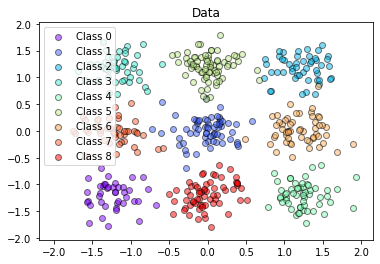

In [20]:
plt.figure()
y_unique = np.unique(y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X_train[y_train == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1],
                c=color[np.newaxis, :],
                alpha=0.5, edgecolor='k',
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.title("Data")

In [21]:
print(y_unique)

[0 1 2 3 4 5 6 7 8]


In [22]:
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import ModelCheckpoint

In [23]:
def compile_model(model, lr=0.001):
    optim = optimizers.Adam(lr=lr)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
def get_model(initial_weights=None, input_dim=2, compile_model_flag=True, lr=0.001, activation='tanh', kernel_initializer=initializers.glorot_uniform(), reduce = 2,  output_size = 3):
    # Creo el modelo
    inp = Input(shape=(input_dim,))
    #bias_initializer = initializers.RandomUniform(-0.1, 0.1)
    bias_initializer = initializers.glorot_uniform()
    #bias_initializer = initializers.zeros()
    first_layer_out = Dense(784//reduce, activation=activation, name='hidden_1', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer, input_shape=(input_dim,))(inp)
    second_layer_out = Dense(784//reduce, activation=activation, name='hidden_2', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)(first_layer_out)
    output = Dense(output_size, name='Salida', kernel_initializer=kernel_initializer, bias_initializer=bias_initializer, activation='softmax')(second_layer_out)
    model = Model(inp, output)
    model_multiple_out = Model(inp, [first_layer_out, second_layer_out, output])
    if compile_model_flag:
        compile_model(model, lr=lr)
    if initial_weights is not None:
        model.save_weights(initial_weights)
    return model, model_multiple_out

model, model_multiple_out = get_model(input_dim=2, output_size=len(y_unique))
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 392)               1176      
_________________________________________________________________
hidden_2 (Dense)             (None, 392)               154056    
_________________________________________________________________
Salida (Dense)               (None, 9)                 3537      
Total params: 158,769
Trainable params: 158,769
Non-trainable params: 0
_________________________________________________________________


In [24]:
initial_weights = 'mlp.blobs.initial.hdf5'
best_weights = 'mlp.blobs.best.hdf5'
model, model_multiple_out = get_model(input_dim=2, output_size=len(y_unique))
model.save_weights(initial_weights)
epochs = 5
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[
    ModelCheckpoint(filepath=best_weights,  verbose=0, save_best_only=True, monitor='val_loss', mode='auto')
])
model.load_weights(best_weights)

Epoch 1/5
16/16 [==============================] - 0s 12ms/step - loss: 1.3245 - accuracy: 0.5840 - val_loss: 0.7253 - val_accuracy: 0.8647
Epoch 2/5
16/16 [==============================] - 0s 9ms/step - loss: 0.5340 - accuracy: 0.9440 - val_loss: 0.3583 - val_accuracy: 0.9676
Epoch 3/5
16/16 [==============================] - 0s 9ms/step - loss: 0.2829 - accuracy: 0.9580 - val_loss: 0.2146 - val_accuracy: 0.9762
Epoch 4/5
16/16 [==============================] - 0s 9ms/step - loss: 0.1783 - accuracy: 0.9700 - val_loss: 0.1579 - val_accuracy: 0.9762
Epoch 5/5
16/16 [==============================] - 0s 9ms/step - loss: 0.1401 - accuracy: 0.9740 - val_loss: 0.1253 - val_accuracy: 0.9762


In [25]:
from LTH_helper import prune_and_initilize, plot_MC_boundaries_keras

In [ ]:
pms = np.linspace(0.0001, 0.9999, 50)
accs = []
model.load_weights(best_weights)
for i, pm in enumerate(pms):
    pruned_model = prune_and_initilize(model, pm, initial_weights)
    acc = pruned_model.evaluate(X_test, y_test, verbose=0)[1]
    accs.append(acc)
    print(i, pm, acc)

0 0.0001 0.11311110854148865
1 0.020504081632653062 0.11311110854148865
2 0.04090816326530613 0.11311110854148865
3 0.061312244897959195 0.11311110854148865
4 0.08171632653061225 0.14666666090488434
5 0.10212040816326531 0.21555554866790771
6 0.12252448979591839 0.28377777338027954
7 0.14292857142857143 0.3024444580078125
8 0.1633326530612245 0.2993333339691162
9 0.18373673469387755 0.3042222261428833
10 0.2041408163265306 0.32555556297302246
11 0.22454489795918367 0.36933332681655884
12 0.24494897959183676 0.4095555543899536
13 0.2653530612244898 0.47066667675971985


In [27]:
plt.plot(pms, accs)

In [28]:
model.load_weights(initial_weights)
model.evaluate(X_test, y_test, verbose=0)[1]

0.11533333361148834

16/16 [==============================] - 0s 5ms/step - loss: 0.1191 - accuracy: 0.9740


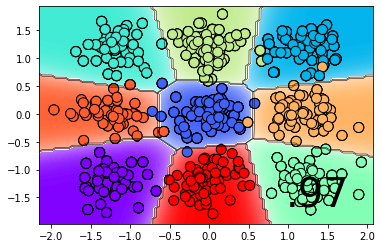

In [29]:
model.load_weights(best_weights)
acc = model.evaluate(X_train, y_train)[1]
xx, yy, Z = plot_MC_boundaries_keras(X_train, y_train, acc, model.predict, my_colors=colors, mesh_res = 100, alpha=1.0, almost_white=0.99)

16/16 [==============================] - 0s 875us/step - loss: 0.9171 - accuracy: 0.8260
0.8259999752044678


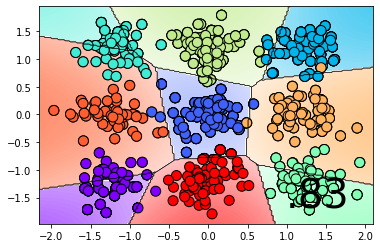

In [30]:
pruned_model = prune_and_initilize(model, 0.5, initial_weights)
acc = pruned_model.evaluate(X_train, y_train)[1]
print(acc)
xx, yy, Z = plot_MC_boundaries_keras(X_train, y_train, acc, pruned_model.predict, my_colors=colors, mesh_res = 200, alpha=1.0, almost_white=0.99)